# VLB Bayesian Workflow

**VLB transient network — Full NLSQ → NUTS inference pipeline**

## Context: Bayesian Inference for VLB

This notebook demonstrates the **complete Bayesian workflow** for VLB parameter estimation: NLSQ point estimation → NUTS sampling → convergence diagnostics → posterior predictive checks. 

The VLB model has only **2 fundamental parameters** ($G_0$, $k_d$), making it ideal for Bayesian inference:
- Well-defined posterior (no identifiability issues)
- NLSQ provides excellent warm-start for MCMC
- Fast convergence (R-hat < 1.01 with 1000 warmup samples)
- Derived quantities ($t_R = 1/k_d$, $\eta_0 = G_0/k_d$, $\Psi_1 = 2G_0/k_d^2$) inherit posterior uncertainty

**Why Bayesian?** Beyond point estimates, we obtain:
1. **Credible intervals** — quantify parameter uncertainty
2. **Derived quantity distributions** — propagate uncertainty through nonlinear transformations
3. **Model comparison** — Bayes factors for VLBLocal vs VLBMultiNetwork
4. **Posterior predictive checks** — verify model adequacy

> **Handbook:** See [VLB Knowledge](../../docs/source/models/vlb/vlb_knowledge.rst) for cross-protocol validation workflow and parameter identifiability discussion.

## Learning Objectives

- Complete NLSQ → NUTS Bayesian workflow for VLBLocal
- Evaluate convergence diagnostics (R-hat, ESS, divergences)
- Construct posterior predictive checks
- Compare posteriors from different protocols

## Estimated Runtime

- Fast demo (1 chain): ~2 min
- Full run (4 chains): ~5-10 min

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import VLBLocal

jax, jnp = safe_import_jax()
verify_float64()
warnings.filterwarnings("ignore", category=FutureWarning)  # JAX/equinox upstream deprecation churn — not actionable in user notebooks
print(f"JAX version: {jax.__version__}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

JAX version: 0.8.3


## 2. Generate Synthetic SAOS Data

In [3]:
# Ground truth
G0_true = 5000.0   # Pa
kd_true = 2.0      # 1/s
tR = 1.0 / kd_true

np.random.seed(42)
omega = np.logspace(-2, 3, 40)

G_prime_true = G0_true * (omega * tR)**2 / (1 + (omega * tR)**2)
G_double_prime_true = G0_true * (omega * tR) / (1 + (omega * tR)**2)

# 3% noise
noise = 0.03
G_prime = G_prime_true * (1 + noise * np.random.randn(len(omega)))
G_double_prime = G_double_prime_true * (1 + noise * np.random.randn(len(omega)))
G_star = G_prime + 1j * G_double_prime

print(f"True: G₀ = {G0_true} Pa, k_d = {kd_true} 1/s")
print(f"Data: {len(omega)} frequencies, ω = [{omega.min():.3f}, {omega.max():.0f}] rad/s")

True: G₀ = 5000.0 Pa, k_d = 2.0 1/s
Data: 40 frequencies, ω = [0.010, 1000] rad/s


## 3. Step 1: NLSQ Point Estimation

In [4]:
model = VLBLocal()

t0 = time.time()
model.fit(omega, G_star, test_mode="oscillation")
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"G₀  = {model.G0:.1f} Pa (true: {G0_true})")
print(f"k_d = {model.k_d:.4f} 1/s (true: {kd_true})")

# Fit quality — use predict_saos for G', G'' and compare with |G*|
G_prime_pred, G_double_prime_pred = model.predict_saos(omega)
G_star_pred_abs = np.sqrt(np.array(G_prime_pred)**2 + np.array(G_double_prime_pred)**2)
G_star_data_abs = np.abs(G_star)
ss_res = np.sum((G_star_data_abs - G_star_pred_abs)**2)
ss_tot = np.sum((G_star_data_abs - np.mean(G_star_data_abs))**2)
r2 = 1 - ss_res / ss_tot
print(f"R² = {r2:.6f}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.778071s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=10 | final_cost=0.0122 | elapsed=0.778s | final_gradient_norm=0.0016


NLSQ fit time: 1.08 s
G₀  = 4945.8 Pa (true: 5000.0)
k_d = 1.9868 1/s (true: 2.0)
R² = 0.997953


## 4. Step 2: Bayesian Inference with NUTS

In [5]:
# --- Fast demo config ---
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# --- Production config (uncomment for full run) ---
# NUM_WARMUP = 1000
# NUM_SAMPLES = 2000
# NUM_CHAINS = 4

# Warm-start from NLSQ
initial_values = {"G0": float(model.G0), "k_d": float(model.k_d)}
print(f"Warm-start: {initial_values}")

t0 = time.time()
result = model.fit_bayesian(
    omega, G_star, test_mode="oscillation",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start: {'G0': 4945.762604018413, 'k_d': 1.9868300336010698}


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<06:55,  1.68it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

sample:  70%|███████   | 490/700 [00:00<00:00, 948.75it/s, 3 steps of size 5.67e-01. acc. prob=0.92]

sample: 100%|██████████| 700/700 [00:00<00:00, 956.62it/s, 7 steps of size 5.67e-01. acc. prob=0.92]


Bayesian inference time: 2.9 s


## 5. Convergence Diagnostics

In [6]:
diag = result.diagnostics
param_names = ["G0", "k_d"]

print("Convergence Diagnostics")
print("=" * 50)
print(f"{'Parameter':>10s}  {'R-hat':>8s}  {'ESS':>8s}")
print("-" * 50)
for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    print(f"{p:>10s}  {r_hat:8.4f}  {ess:8.0f}")

n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

r_hat_ok = all(diag.get("r_hat", {}).get(p, 2.0) < 1.05 for p in param_names)
ess_ok = all(diag.get("ess", {}).get(p, 0) > 100 for p in param_names)
print(f"\nConvergence: {'PASSED' if r_hat_ok and ess_ok else 'CHECK REQUIRED'}")

Convergence Diagnostics
 Parameter     R-hat       ESS
--------------------------------------------------
        G0    1.0006       457
       k_d    0.9984       456

Divergences: 0

Convergence: PASSED


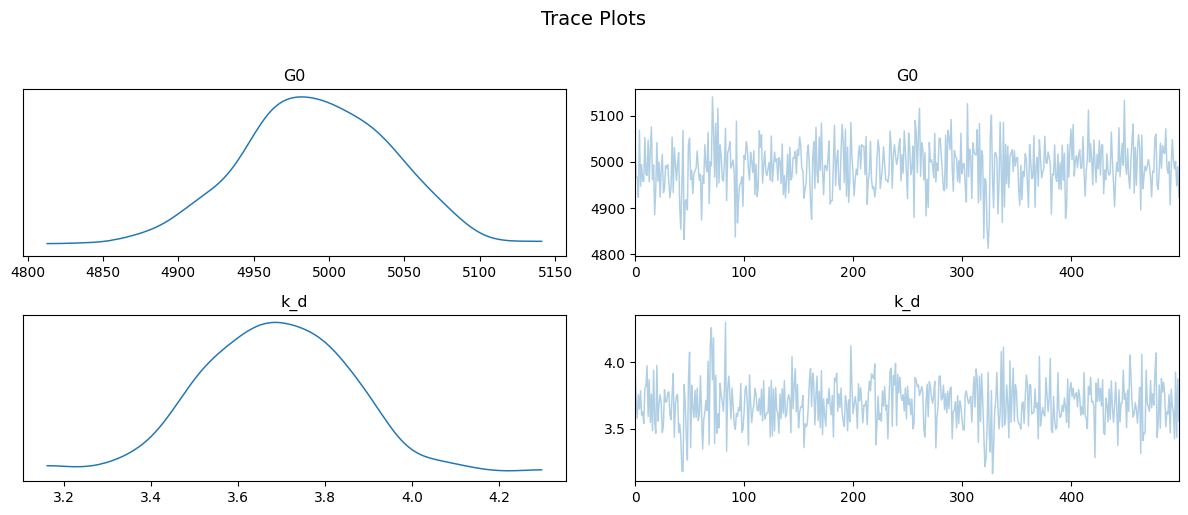

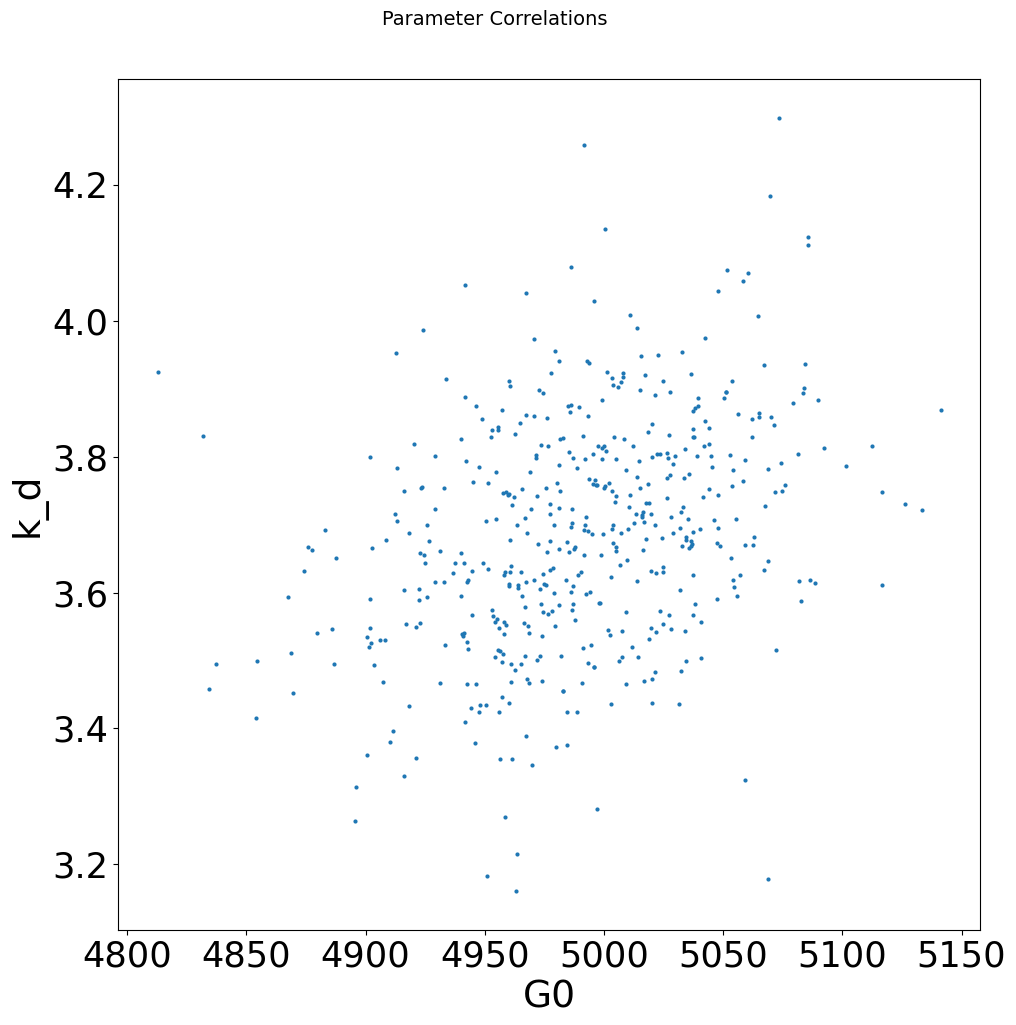

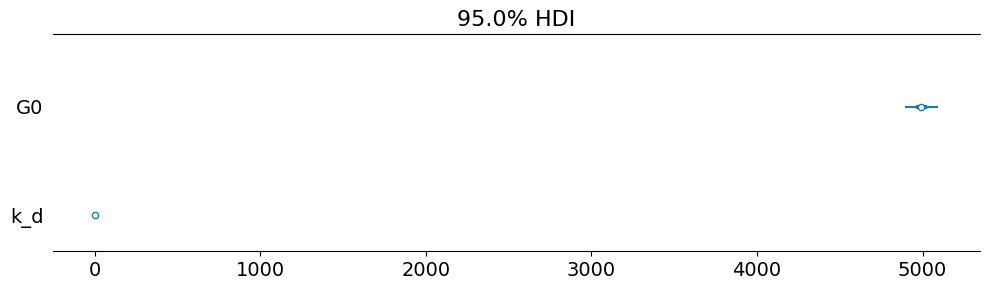

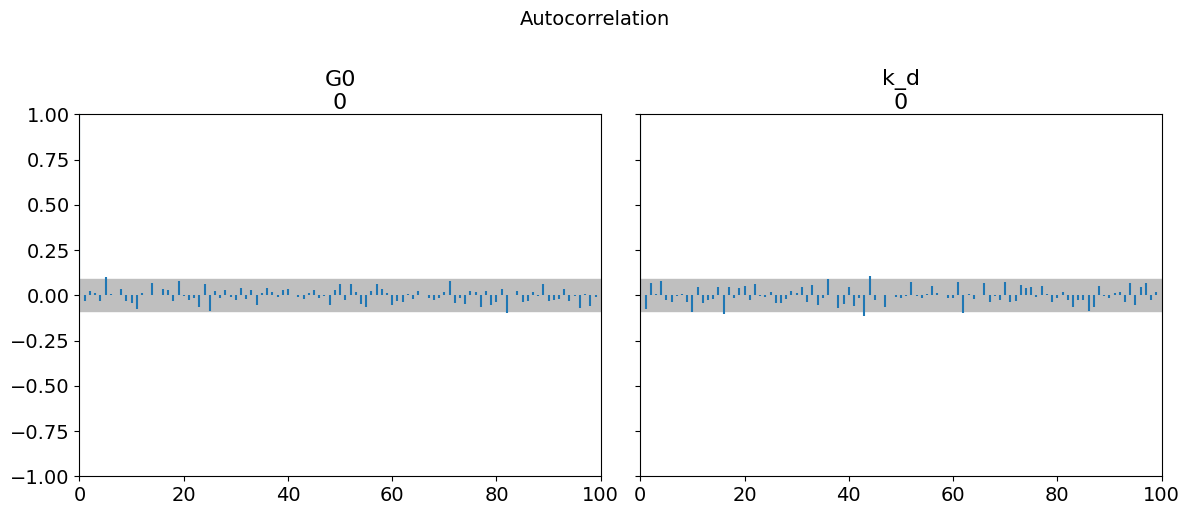

In [7]:
display_arviz_diagnostics(result, param_names, fast_mode=os.environ.get("FAST_MODE", "1") == "1")

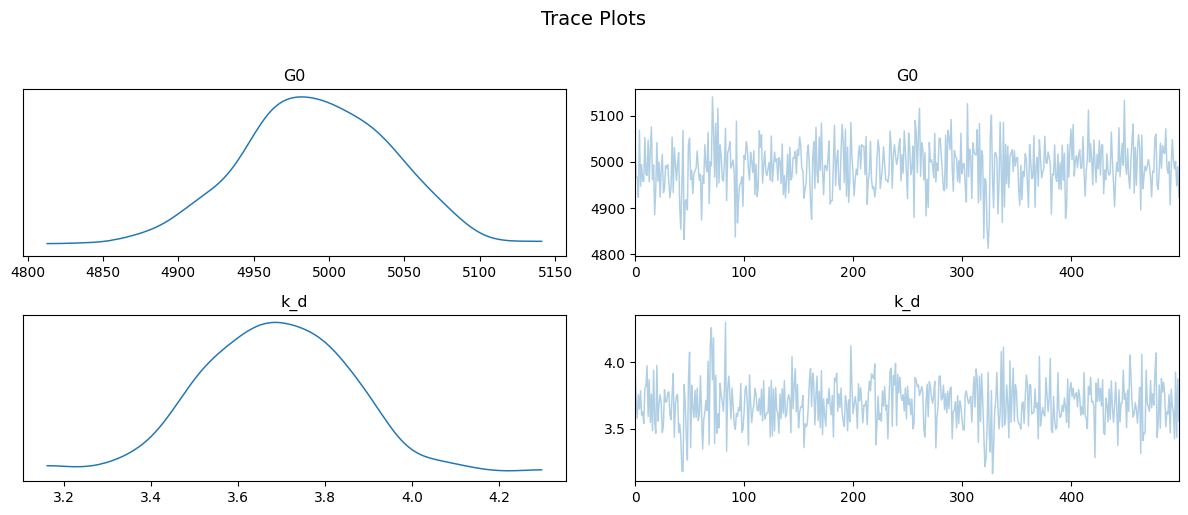

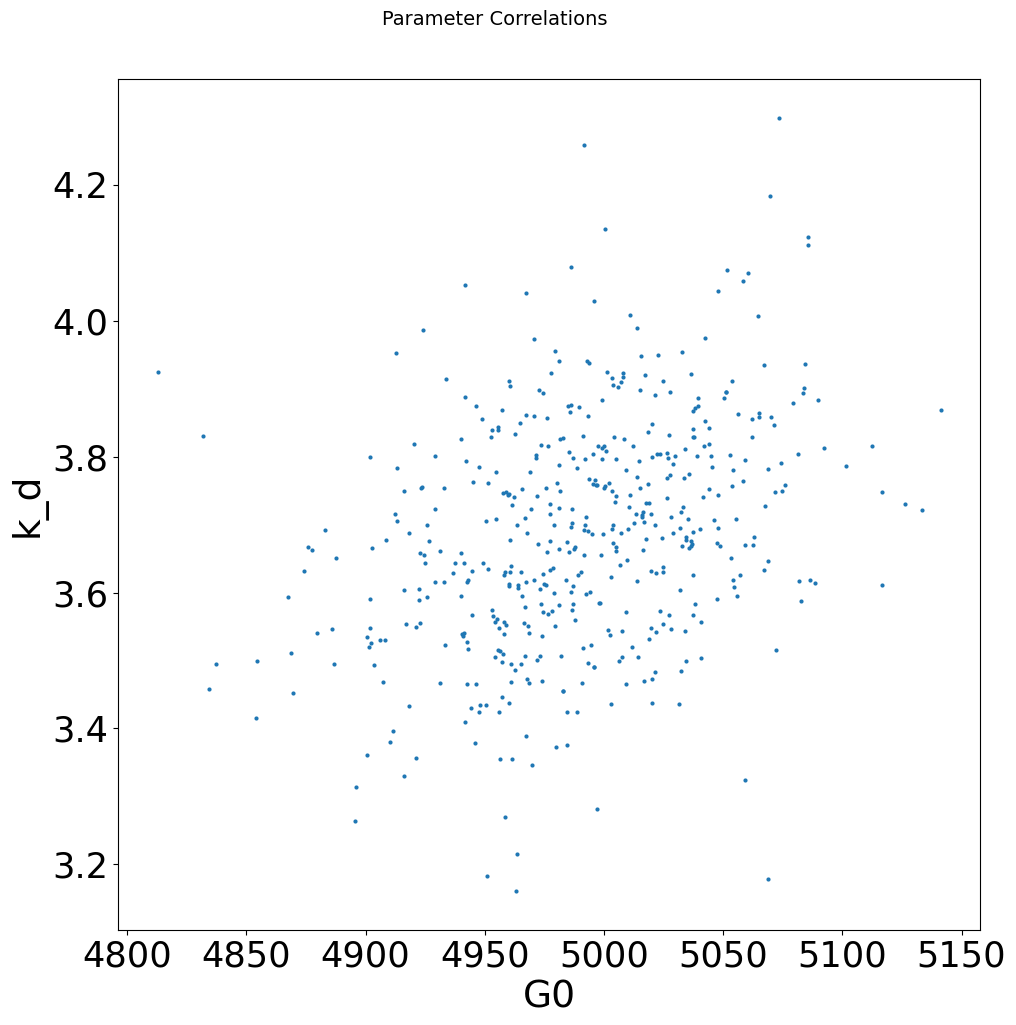

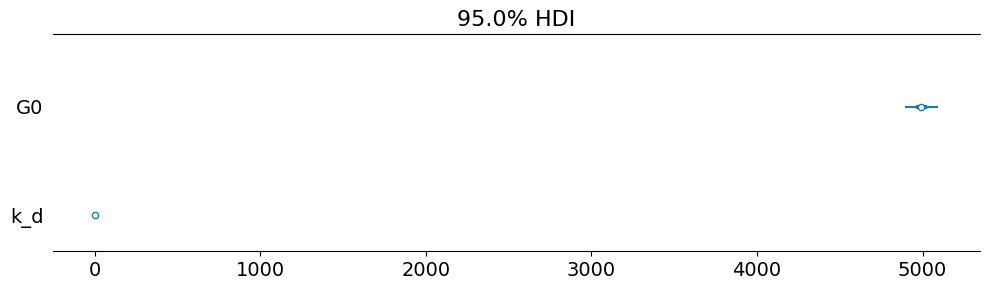

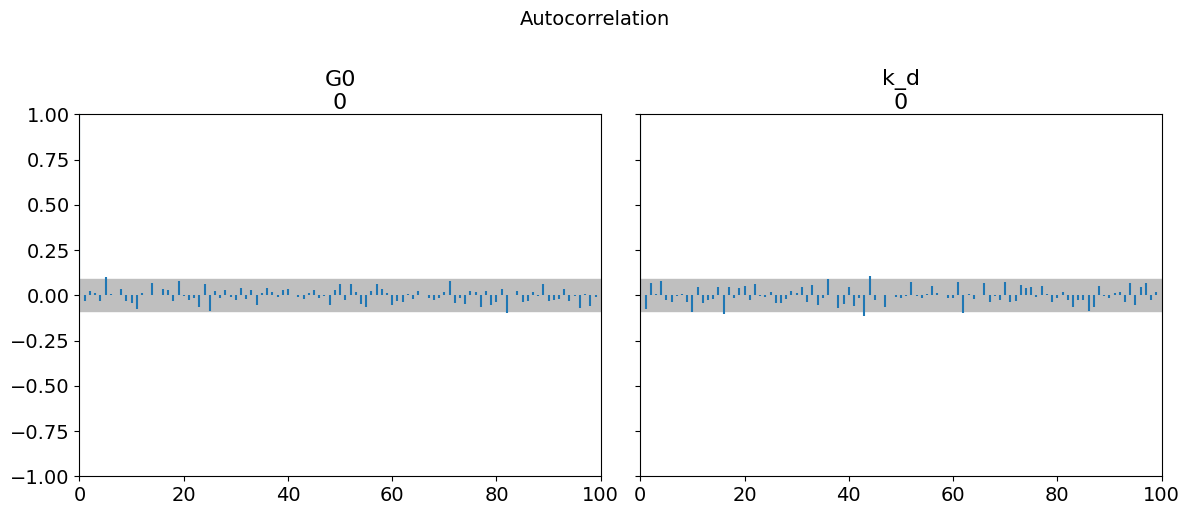

In [8]:
display_arviz_diagnostics(result, param_names, fast_mode=os.environ.get("FAST_MODE", "1") == "1")

## 6. Posterior Summary

In [9]:
posterior = result.posterior_samples

print("Parameter Comparison")
print("=" * 60)
print(f"{'Param':>8s}  {'True':>8s}  {'NLSQ':>10s}  {'Bayes (median)':>14s}  {'95% CI':>20s}")
print("-" * 60)

true_vals = {"G0": G0_true, "k_d": kd_true}
nlsq_vals = {"G0": model.G0, "k_d": model.k_d}

for p in param_names:
    samples = np.array(posterior[p])
    med = np.median(samples)
    lo, hi = np.percentile(samples, [2.5, 97.5])
    print(f"{p:>8s}  {true_vals[p]:8.1f}  {nlsq_vals[p]:10.1f}  {med:14.1f}  [{lo:.1f}, {hi:.1f}]")

Parameter Comparison
   Param      True        NLSQ  Bayes (median)                95% CI
------------------------------------------------------------
      G0    5000.0      4945.8          4991.0  [4881.2, 5085.0]
     k_d       2.0         2.0             3.7  [3.4, 4.0]


## 7. Posterior Predictive Check

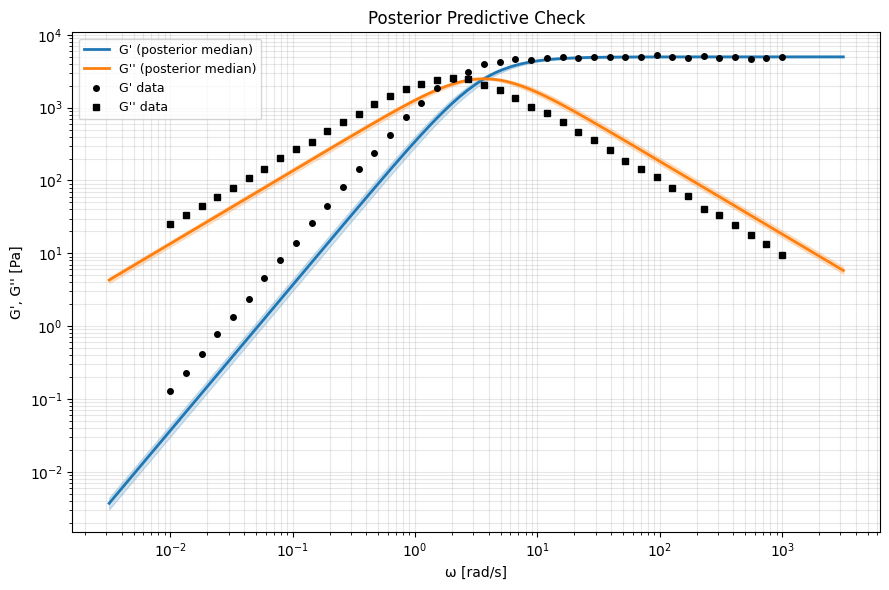

In [10]:
omega_fine = np.logspace(-2.5, 3.5, 200)
n_draws = min(200, len(posterior["G0"]))

Gp_samples = []
Gdp_samples = []

for i in range(n_draws):
    model.parameters.set_value("G0", float(posterior["G0"][i]))
    model.parameters.set_value("k_d", float(posterior["k_d"][i]))
    Gp_i, Gdp_i = model.predict_saos(omega_fine)
    Gp_samples.append(np.array(Gp_i))
    Gdp_samples.append(np.array(Gdp_i))

Gp_arr = np.array(Gp_samples)
Gdp_arr = np.array(Gdp_samples)

fig, ax = plt.subplots(figsize=(9, 6))

# 95% CI bands
ax.fill_between(omega_fine, np.percentile(Gp_arr, 2.5, axis=0),
                np.percentile(Gp_arr, 97.5, axis=0), alpha=0.2, color="C0")
ax.fill_between(omega_fine, np.percentile(Gdp_arr, 2.5, axis=0),
                np.percentile(Gdp_arr, 97.5, axis=0), alpha=0.2, color="C1")

# Medians
ax.loglog(omega_fine, np.median(Gp_arr, axis=0), "C0-", lw=2, label="G' (posterior median)")
ax.loglog(omega_fine, np.median(Gdp_arr, axis=0), "C1-", lw=2, label="G'' (posterior median)")

# Data
ax.loglog(omega, np.real(G_star), "ko", markersize=4, label="G' data")
ax.loglog(omega, np.imag(G_star), "ks", markersize=4, label="G'' data")

ax.set_xlabel("ω [rad/s]")
ax.set_ylabel("G', G'' [Pa]")
ax.set_title("Posterior Predictive Check")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 8. Derived Quantities with Uncertainty

In [11]:
G0_samples = np.array(posterior["G0"])
kd_samples = np.array(posterior["k_d"])

tR_samples = 1.0 / kd_samples
eta_samples = G0_samples / kd_samples
Psi1_samples = 2.0 * G0_samples / kd_samples**2

print("Derived Quantities (posterior)")
print("=" * 55)
for name, samples, true_val in [
    ("t_R [s]", tR_samples, 1/kd_true),
    ("η₀ [Pa·s]", eta_samples, G0_true/kd_true),
    ("Ψ₁ [Pa·s²]", Psi1_samples, 2*G0_true/kd_true**2),
]:
    med = np.median(samples)
    lo, hi = np.percentile(samples, [2.5, 97.5])
    print(f"  {name:12s}: {med:.1f} [{lo:.1f}, {hi:.1f}] (true: {true_val:.1f})")

Derived Quantities (posterior)
  t_R [s]     : 0.3 [0.2, 0.3] (true: 0.5)
  η₀ [Pa·s]   : 1354.7 [1241.4, 1476.4] (true: 2500.0)
  Ψ₁ [Pa·s²]  : 735.2 [616.4, 878.3] (true: 2500.0)


## 9. Save Results

In [12]:
import json
import os

output_dir = os.path.join("..", "outputs", "vlb", "bayesian")
os.makedirs(output_dir, exist_ok=True)

posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
with open(os.path.join(output_dir, "posterior_samples.json"), "w") as f:
    json.dump(posterior_dict, f)

print(f"Saved to {output_dir}/")

Saved to ../outputs/vlb/bayesian/


## Key Takeaways

1. **NLSQ warm-start is critical** for fast NUTS convergence
2. **VLBLocal has only 2 parameters** → well-identified posteriors
3. **R-hat < 1.01 and ESS > 400** are the convergence targets
4. **Derived quantities** ($t_R$, $\eta_0$, $\Psi_1$) inherit uncertainty from the posterior
5. **Posterior predictive checks** verify the model captures the data

## Further Reading

- [VLB Model Reference](../../docs/source/models/vlb/vlb.rst) — SAOS analytical solutions for posterior predictive
- [VLB Knowledge Extraction](../../docs/source/models/vlb/vlb_knowledge.rst) — cross-protocol validation workflow, parameter identifiability
- Vernerey, F.J., Long, R. & Brighenti, R. (2017). *J. Mech. Phys. Solids*, 107, 1-20.

## Production Tips

- Use `num_chains=4` for proper convergence diagnostics
- Use `num_warmup=1000, num_samples=2000` for publication-quality results
- Check `az.plot_energy()` for sampling efficiency
- If divergences appear, increase `num_warmup` or check parameter bounds